## Data Preparation:

* Filter the dataset for a specific hotel type.
* Convert booking dates to datetime and count daily bookings.
* Handle any missing dates in the time series.

## Implementing Models with sktime:

* Implement naive, moving average, and exponential smoothing forecasters.
* Train and evaluate models.

## If time permits

* Play around with advanced functionalities and pipelining

In [29]:
import pandas as pd

# Load the data
df = pd.read_csv('hotel_bookings.csv')

# Create a single timestamp column
df['date'] = df['arrival_date_day_of_month'].astype(str) + ' ' + df['arrival_date_month'] + ' ' + df['arrival_date_year'].astype(str)

df['date'] = pd.to_datetime(df['date'])

In [30]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31


In [31]:
df.groupby(["hotel","date"]).size()['Resort Hotel']

date
2015-07-01    43
2015-07-02    44
2015-07-03    40
2015-07-04    50
2015-07-05    45
              ..
2017-08-27    67
2017-08-28    78
2017-08-29    35
2017-08-30    42
2017-08-31    55
Length: 793, dtype: int64

In [32]:
y = df.groupby(["hotel","date"]).size()['City Hotel'].reset_index(name='demand')

In [33]:
y.set_index('date', inplace=True)
y = y.asfreq('D').fillna(0.0)
y = y.resample('ME')['demand'].sum()

In [34]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 26 entries, 2015-07-31 to 2017-08-31
Freq: ME
Series name: demand
Non-Null Count  Dtype
--------------  -----
26 non-null     int64
dtypes: int64(1)
memory usage: 416.0 bytes


In [35]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(smoothing_level=0.2, seasonal="add", sp=12)
forecaster.fit(y)

ExponentialSmoothing(seasonal='add', smoothing_level=0.2, sp=12)

In [36]:
from sktime.forecasting.naive import NaiveForecaster
naive_forecaster = NaiveForecaster(sp=12)
naive_forecaster.fit(y)

NaiveForecaster(sp=12)

In [37]:

from sktime.forecasting.base import ForecastingHorizon
sktime_fh = ForecastingHorizon(range(-12,12), is_relative=True)
y_pred_ES = forecaster.predict(fh=sktime_fh)
y_pred_naive = naive_forecaster.predict(fh=sktime_fh)

In [38]:
prediction_data = pd.DataFrame({'ES':y_pred_ES, 'naive':y_pred_naive})
prediction_data

,ES,naive
2016-08-31,2875.194679,2480.0
2016-09-30,3823.472185,3529.0
2016-10-31,3932.885610,3386.0
2016-11-30,2388.649660,1235.0
2016-12-31,2326.766295,1654.0
2017-01-31,2097.577214,1364.0
2017-02-28,2764.828566,2371.0
2017-03-31,3428.443434,3046.0
2017-04-30,3894.266074,3561.0
2017-05-31,4198.855841,3676.0


In [39]:
y.index

DatetimeIndex(['2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29',
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31'],
              dtype='datetime64[ns]', name='date', freq='ME')

In [40]:
prediction_data.index

DatetimeIndex(['2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31'],
              dtype='datetime64[ns]', freq='ME')

In [41]:
evaluationData = pd.merge(y,prediction_data,how="inner", left_index=True, right_index=True)
evaluationData

,demand,ES,naive
2016-08-31,3378,2875.194679,2480.0
2016-09-30,3871,3823.472185,3529.0
2016-10-31,4219,3932.885610,3386.0
2016-11-30,3122,2388.649660,1235.0
2016-12-31,2478,2326.766295,1654.0
2017-01-31,2372,2097.577214,1364.0
2017-02-28,2594,2764.828566,2371.0
2017-03-31,3412,3428.443434,3046.0
2017-04-30,3919,3894.266074,3561.0
2017-05-31,4556,4198.855841,3676.0


In [42]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(evaluationData['demand'],evaluationData['ES'])

/usr/local/python/3.10.13/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


np.float64(0.08327954504947171)

In [43]:
mae = MeanAbsoluteError()
mae(evaluationData['demand'],evaluationData['ES'])

/usr/local/python/3.10.13/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


np.float64(273.8797186482029)

In [47]:
print("mae",mae(evaluationData['demand'],evaluationData['naive']))
print("mape",mape(evaluationData['demand'],evaluationData['naive']))


mae 642.1538461538462
mape 0.20035195719617954


/usr/local/python/3.10.13/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/python/3.10.13/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='demand'>)

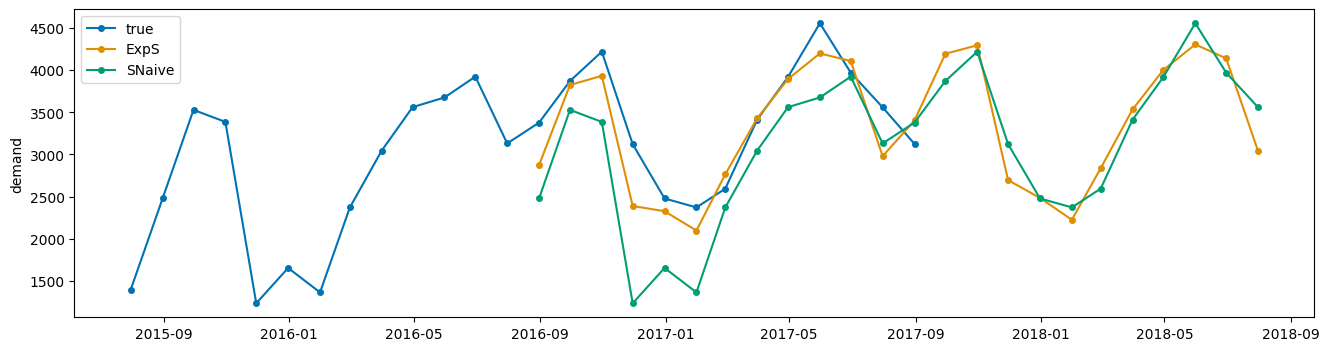

In [45]:
from sktime.utils.plotting import plot_series
plot_series(y, y_pred_ES, y_pred_naive, labels=['true','ExpS','SNaive'])